In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import cv2
from numpy.lib.stride_tricks import as_strided

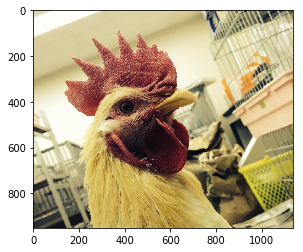

In [24]:
img = cv2.imread('./1549080769074.jpg')
img_r = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_r)

## 平均化フィルタ（averaging filter)

In [194]:
def image_process(src, kernel):
    """
    画像をフィルタに通して出力する
    """
    width, height = src.shape[0],src.shape[1]

    img_pixels = np.array([[src[x,y] for y in range(height)] for x in range(width)])
    color = np.zeros((len(kernel), 3))
    
    #各ピクセルを注目点として、一つ一つの近傍領域を取得する。
    for y in range(1, height-1):
        for x in range(1, width-1):
            color[0] = img_pixels[x-1][y-1]
            color[1] = img_pixels[x-1][y]
            color[2] = img_pixels[x-1][y+1]
            color[3] = img_pixels[x][y-1]
            color[4] = img_pixels[x][y]
            color[5] = img_pixels[x][y+1]
            color[6] = img_pixels[x+1][y-1]
            color[7] = img_pixels[x+1][y]
            color[8]= img_pixels[x+1][y+1]

            sum_color = np.zeros(3)
            for num in range(len(kernel)):
                sum_color += color[num] * kernel[num]

            r,g,b = map(int, (sum_color))
            r = min([r, 255])
            r = max([r, 0])
            g = min([g, 255])
            g = max([g, 0])
            b = min([b, 255])
            b = max([b, 0])

            src[x, y] = [b, g, r]
            
    return src

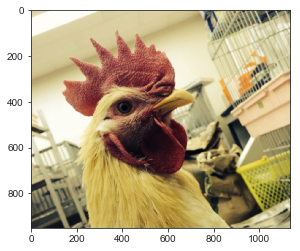

In [195]:
#scratch 3*3 karnel 
width, height, rgb= img.shape
img_pixels = [[img[x, y] for y in range(height)] for x in range(width)]
cp_img = img_r.copy()

kernel =(1/9)* np.ones([9])
color = np.zeros((len(karnel), 3))

plt.imshow(image_process(img_r, kernel))

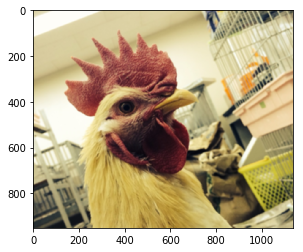

In [60]:
#7*7 karnel 
kernel = (1/49)*np.ones([7,7])
dst = cv2.filter2D(img_r, -1, kernel)
plt.imshow(dst)

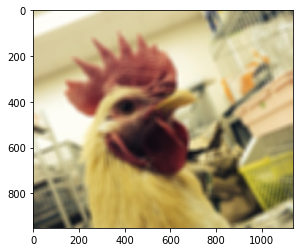

In [75]:
# 25*25 karnel 
kernel = (1/625)*np.ones([25,25])
dst = cv2.filter2D(img_r, -1, kernel)
plt.imshow(dst)

## ガウシアンフィルタ（Gaussian filter)

平均:0, 分散: σ2 の二次元正規分布:<br>
$
G(x, y, σ) = 1/2πσ^{2}exp(-({x^{2}+y^{2}})/2σ^{2})
$

In [85]:
def norm2d(x,y,sigma):
    """
    ガウス分布（2次元正規分布）
    """
    Z = np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return Z

In [95]:
# #ガウス分布のプロット
# sns.set_style('ticks')
# fig = plt.figure(figsize=(10, 8))
# ax = Axes3D(fig)

# # x = y = np.arange(-3,3,0.1) これ？が例
# # X, Y= np.meshgrid(img_r[0], img_r[1])　　これは違う
# X, Y= img_r[0], img_r[1]　これ？なんか変

# ax.plot_surface(X,Y,norm2d(X,Y,1),cmap='coolwarm')
# plt.show()

In [103]:
def gaussian_kernel(size):
    """
    ガウシアンフィルタを作成して返す
    """
    #フィルタサイズ (2w + 1)(2w + 1) の場合，σ = w/2 とするのが一つの目安」らしい
    sigma = (size-1)/2
    
    # [0,size]→[-sigma, sigma] にずらす
    x = y= np.arange(0, size) - sigma
    X,Y = np.meshgrid(x,y) 
    
    mat = norm2d(x, y, sigma)
    
    #総和が１になるように
    kernel = mat/np.sum(mat)
    return kernel

In [105]:
def convolve2d_1ch(img, kernel, padding='0'):
    """
    畳み込み
    """
    edge = int(kernel.shape[0]/2)
    
    # 境界をどうするか
    if padding=='edge':
        img = np.pad(img, [edge,edge], mode='edge')#edge:配列の辺の値で埋め込む
    elif padding=='reflect':
        img = np.pad(img, [edge,edge], mode='reflect') #reflect:最初と最後の値で埋め込み
    else:
        img = np.pad(img, [edge,edge], mode='constant', constant_values=0)#consant ：　両端を０で埋め込み
        
    sub_shape = tuple(np.subtract(img.shape, kernel.shape) + 1)
    
    # (rows, cols, N, N)
    conv_shape = sub_shape + kernel.shape

    # A.strides は (Aのrow方向の一要素ごとのbytes数, col方向のbytes数) のタプル
    # (shape[0]*bytes, bytes, shape[0]*bytes, bytes)
    strides = img.strides + img.strides

    submatrices = as_strided(img, conv_shape, strides)

    # (i,j)配列と(k,l,i,j)配列で, (i,j)要素同士の積和を要素とした(k,l)配列を返す
    convolved_mat = np.einsum('ij, klij->kl', kernel, submatrices)
    
    return convolved_mat

In [112]:
def img_show2(img1,img2,titles=['ref_img','filtered']):
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_title(titles[0]), ax2.set_title(titles[1])
    
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_xticks([]), ax2.set_yticks([])
    
    ax1.imshow(img1)
    ax2.imshow(img2)
    
    plt.show()

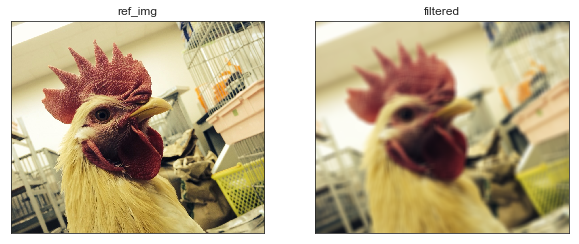

In [113]:
gaussian_kernel(3)
mean_convolved = np.zeros(img_r.shape)

for (i,ch) in enumerate(['R','G','B']):
    mean_convolved[:,:,i] = convolve2d_1ch(img_r[:,:,i], kernel, padding='edge')
    
mean_convolved = mean_convolved.astype('uint8')

img_show2(img_r, mean_convolved)

## バイリテラルフィルタ

エッジなどの有用な情報も低減させないように、エッジ情報を維持しつつ平滑化を行う手法。<br>
ガウシアンフィルタでは、注目画素からの距離に応じて周辺画素に重みをつけたが、バイリテラルフィルタでは距離に加えて、<br>
<strong>注目画素と周辺画素との輝度値の差による重みづけ</strong>を行う。<br>

Text(0.5, 1.0, 'bi3')

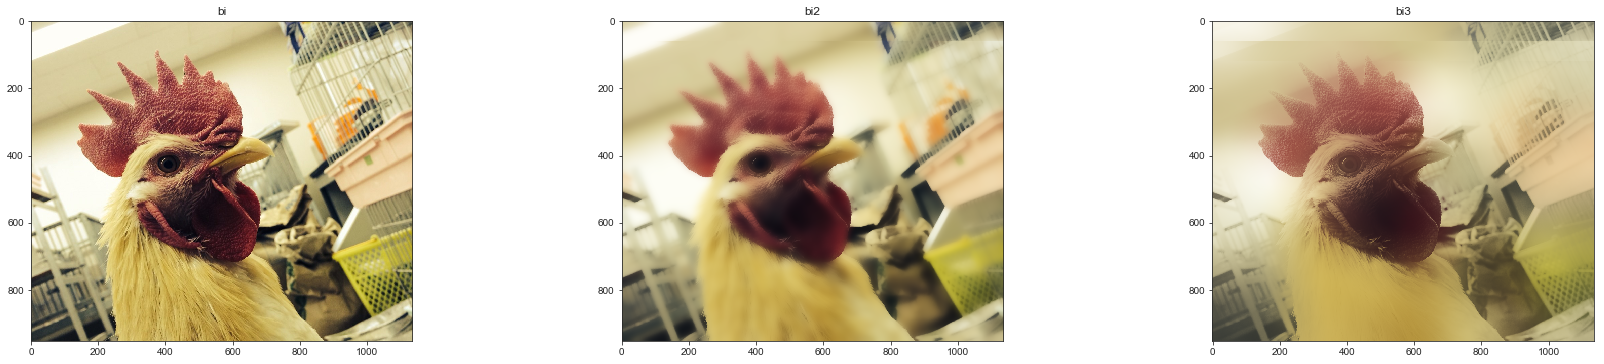

In [131]:
#library cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]]))
#d: 注目画素をぼかすために使われる領域(周辺領域)
#sigmaColor: 色についての標準偏差。これが大きいと、画素値の差が大きくても大きな重みが採用される。
#sigmaSpace: 距離についての標準偏差。これが大きいと、画素間の距離が広くても大きな重みが採用される

bi = img_r
bi2 = cv2.bilateralFilter(img_r, 200, 200, 10)
bi3 = cv2.bilateralFilter(img_r, 200, 200, 200)

fig = plt.figure(figsize=(30, 20))
ax1= fig.add_subplot(3, 3, 1)
ax1.imshow(bi)
ax1.set_title('bi')
ax2= fig.add_subplot(3, 3, 2)
ax2.imshow(bi2)
ax2.set_title('bi2')
ax3= fig.add_subplot(3, 3, 3)
ax3.imshow(bi3)
ax3.set_title('bi3')

## エッジ検出
物体の縁のような点を捉える検出機

<br>

### <１次微分によるエッジ検出>

### プリューウィットフィルタ(Prewitt filter)
注目画素の周辺の画素値の微分も計算し、それらの値の平均を用いる方法。<br>

$
F_{x}=
\begin{pmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{pmatrix}
$
$
, F_{y}=
\begin{pmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1 \\
\end{pmatrix}
$

### ソーベルフィルタ(Sobel filter)

$
F_{x}=
\begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{pmatrix}
$
$
, F_{y}=
\begin{pmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\
\end{pmatrix}
$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


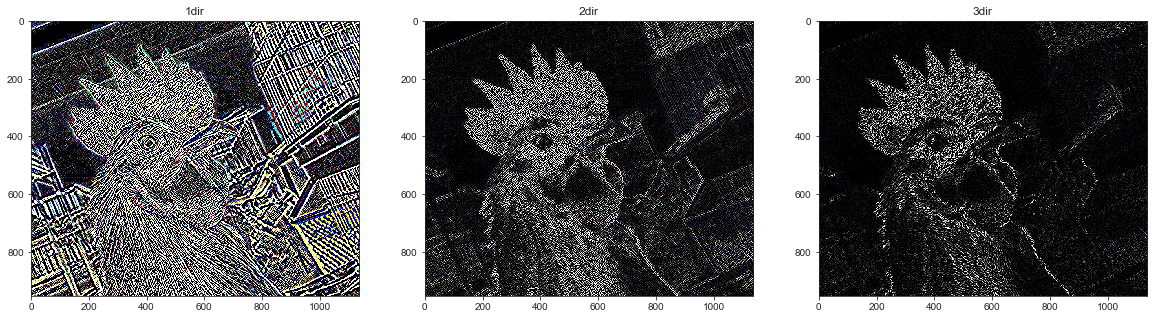

In [164]:
#cv2.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]]) 
#src: 入力画像
# dst: 出力画像
# ddepth: 出力の色深度
# dx: x方向の微分の次数
# dy: y方向の微分の次数
# ksize: カーネルサイズ、1, 3, 5, 7のどれかを指定
img_dir1 = cv2.Sobel(img_r, 2, 1, 1, ksize= 7)#1次微分
img_dir2 = cv2.Sobel(img_r, 2, 2, 2, ksize= 7)#2次微分
img_dir3 = cv2.Sobel(img_r, 2, 3, 3, ksize= 7)#3次微分

fig = plt.figure(figsize=(20, 30))
ax1= fig.add_subplot(3,3,1)
ax1.set_title('1dir')
ax1.imshow(img_dir1)
ax2= fig.add_subplot(3,3,2)
ax2.set_title('2dir')
ax2.imshow(img_dir2)
ax2= fig.add_subplot(3,3,3)
ax2.set_title('3dir')
ax2.imshow(img_dir3)

### <2次微分によるエッジ検出>

### ラプラシアン(Laplacian)
連続系のx方向、y方向の2次微分の和

$
F=
\begin{pmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 \\
\end{pmatrix}
$<br>

下は斜め方向も考慮したカーネル<br>

$
F=
\begin{pmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1 \\
\end{pmatrix}
$

2次微分はノイズ検出してしまう可能性もある。<br>
解決するためには、入力画像にガウシアンフィルタを適用し、ノイズを除去しておく方法が有効。<br>
その方法を、<strong>ラプラシアン・ガウシアンフィルタ(Laplacian of Gaussian filter, LoGフィルタ）</strong>という<br>

$$
LoG(x, y, σ)　= \frac{∂G}{∂x^{2}}+\frac{∂G}{∂y^{2}}
= -\frac{1}{πσ^{4}}(1-\frac{x^{2}+y^{2}{2σ^{2}}}{2σ^{2}})exp(-\frac{x^{2}+y^{2}}{2σ^{2}})
$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


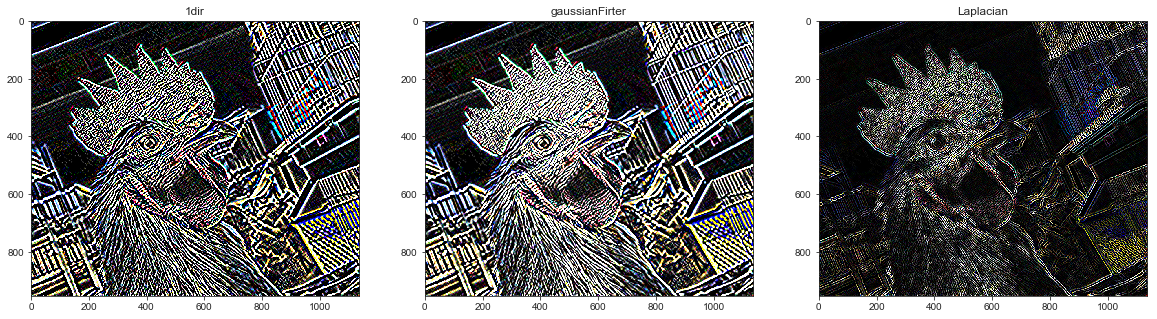

In [205]:
img_dir1 = cv2.Sobel(img_r, 2, 1, 1, ksize= 7)#1次微分
img_dir1_gau = cv2.GaussianBlur(img_dir1, ksize=(3,3), sigmaX=3)#ガウシアンフィルタを適用して、ノイズの除去
img_dir1_gau_lap = cv2.Laplacian(img_dir1_gau, cv2.CV_16U)#ラプラシアンフィルタで２次微分

fig = plt.figure(figsize=(20, 30))
ax1= fig.add_subplot(3,3,1)
ax1.set_title('1dir')
ax1.imshow(img_dir1)
ax2= fig.add_subplot(3,3,2)
ax2.set_title('gaussianFirter')
ax2.imshow(img_dir1_gau)
ax3= fig.add_subplot(3,3,3)
ax3.set_title('Laplacian')
ax3.imshow(img_dir1_gau_lap)

## コーナー検出器
物体の角のような点を見つける検出器。 -> x, y, I空間で<strong>曲率（curvature）</strong>の大きな点を探す。<br>

へシアン行列（ヘッセ行列）<br>
$
H=
\begin{pmatrix}
I_{xx}(x, y) & I_{xy}(x, y) \\
I_{xy}(x, y) & I_{yy}(x, y)\\
\end{pmatrix}
$
<br>
<br>
$
det(H) = I_{xx}I_{yy}-I^{2}_{xy}
$

$

\frac{det(H)}{(1+I^{2}_{x]+I^{2}_{y})^{2}}

$